In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
class Auxiliary(nn.Module):
    def __init__(self):
        super().__init__()
        
        kernel_size = 3
        out_channels1 = 32
        in_channels1 = 1
        out_channels2 = 64
        in_channels2 = 32
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1_1 = nn.Conv2d(in_channels1, out_channels1, kernel_size)
        self.conv1_2 = nn.Conv2d(in_channels2, out_channels2, kernel_size)
        
        self.conv2_1 = nn.Conv2d(in_channels1, out_channels1, kernel_size)
        self.conv2_2 = nn.Conv2d(in_channels2, out_channels2, kernel_size)
        
        in_features1 = 256
        out_features1 = 120
        out_features2 = 10
        
        self.fc1_1 = nn.Linear(in_features1, out_features1)
        self.fc1_2 = nn.Linear(out_features1, out_features2)

        self.fc2_1 = nn.Linear(in_features1, out_features1)
        self.fc2_2 = nn.Linear(out_features1, out_features2)

        
        self.fc3 = nn.Linear(2 * out_features2, 1)
        
    def forward(self, x):
        x1 = x[:,:1,:]
        x2 = x[:,1:2,:]
        
        x1 = self.pool(F.relu(self.conv1_1(x1)))
        x1 = self.pool(F.relu(self.conv1_2(x1)))
        x1 = torch.flatten(x1, 1)
        x1 = F.relu(self.fc1_1(x1))
        x1 = F.relu(self.fc1_2(x1))
        
        x2 = self.pool(F.relu(self.conv2_1(x2)))
        x2 = self.pool(F.relu(self.conv2_2(x2)))
        x2 = torch.flatten(x2, 1)
        x2 = F.relu(self.fc2_1(x2))
        x2 = F.relu(self.fc2_2(x2))
        
        x = self.fc3(torch.cat((x1, x2), dim=1))
        
        return x, x1, x2

In [3]:
model = Auxiliary()

In [4]:
from dataloading import load_data

trainloader, testloader = load_data()

In [5]:
learning_rate = .001

criterion = nn.BCEWithLogitsLoss()
class_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [6]:
epochs = 30

losses = []

for epoch in range(epochs):
    running_loss = 0.0
    epoch_losses = []
    
    for i, data in enumerate(trainloader, 0):
        inputs, target, classes = data
        
        outputs, x1, x2 = model(inputs)
        outputs = outputs.squeeze()
        
        loss = criterion(outputs, target.float())
        
        epoch_losses.append(loss.item())
        
        class_loss1 = class_criterion(x1, classes[:,0])
        class_loss2 = class_criterion(x2, classes[:,1])
        
        loss += class_loss1 + class_loss2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        
    
    epoch_loss = torch.mean(torch.tensor(epoch_losses))
    print(f'epoch: {epoch}, loss: {epoch_loss}')
    losses.append(epoch_loss)  

epoch: 0, loss: 0.9438272714614868
epoch: 1, loss: 0.7361870408058167
epoch: 2, loss: 0.7364409565925598
epoch: 3, loss: 0.7409769296646118
epoch: 4, loss: 0.7474815249443054
epoch: 5, loss: 0.7507487535476685
epoch: 6, loss: 0.7505138516426086
epoch: 7, loss: 0.7425477504730225
epoch: 8, loss: 0.7380112409591675
epoch: 9, loss: 0.7319474220275879
epoch: 10, loss: 0.7260680794715881
epoch: 11, loss: 0.7157115340232849
epoch: 12, loss: 0.7085597515106201
epoch: 13, loss: 0.7014140486717224
epoch: 14, loss: 0.6932560205459595
epoch: 15, loss: 0.6874130368232727
epoch: 16, loss: 0.6805800795555115
epoch: 17, loss: 0.6762203574180603
epoch: 18, loss: 0.666435182094574
epoch: 19, loss: 0.6613039374351501
epoch: 20, loss: 0.6585345268249512
epoch: 21, loss: 0.6538094282150269
epoch: 22, loss: 0.6513364315032959
epoch: 23, loss: 0.647131621837616
epoch: 24, loss: 0.6449662446975708
epoch: 25, loss: 0.6426534056663513
epoch: 26, loss: 0.6365044116973877
epoch: 27, loss: 0.6313144564628601
epoc

In [7]:
from evaluate import evaluate_model

def model_fn(x):
    outputs, _, _ = model(x)
    
    return outputs
    

evaluate_model(model_fn, testloader)

Accuracy: 0.593999981880188


tensor(0.5940)

In [8]:
from evaluate import evaluate_model

l = []
a = []

epochs = 30

for round in range(20):
    print('####################################################')
    print(f'Round: {round}')
    print('####################################################')
    
    model = Auxiliary()
    
    def model_fn(x):
        outputs, _, _ = model(x)

        return outputs
    
    trainloader, testloader = load_data()
    
    learning_rate = .001

    criterion = nn.BCEWithLogitsLoss()
    class_criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    losses = []
    accs = []

    for epoch in range(epochs):
        running_loss = 0.0
        epoch_losses = []

        for i, data in enumerate(trainloader, 0):
            inputs, target, classes = data
        
            outputs, x1, x2 = model(inputs)
            outputs = outputs.squeeze()

            loss = criterion(outputs, target.float())

            epoch_losses.append(loss.item())

            class_loss1 = class_criterion(x1, classes[:,0])
            class_loss2 = class_criterion(x2, classes[:,1])

            loss += class_loss1 + class_loss2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = torch.mean(torch.tensor(epoch_losses))
        print(f'epoch: {epoch}, loss: {epoch_loss}')
        losses.append(epoch_loss) 
        
        acc = evaluate_model(model_fn, testloader)
        accs.append(acc)
    
    l.append(losses)
    a.append(accs)

####################################################
Round: 0
####################################################
epoch: 0, loss: 0.7676899433135986
Accuracy: 0.5490000247955322
epoch: 1, loss: 0.6564497947692871
Accuracy: 0.5479999780654907
epoch: 2, loss: 0.6517865061759949
Accuracy: 0.5490000247955322
epoch: 3, loss: 0.6474131941795349
Accuracy: 0.5490000247955322
epoch: 4, loss: 0.6385542154312134
Accuracy: 0.5490000247955322
epoch: 5, loss: 0.6413231492042542
Accuracy: 0.5509999990463257
epoch: 6, loss: 0.6436537504196167
Accuracy: 0.5509999990463257
epoch: 7, loss: 0.6386974453926086
Accuracy: 0.550000011920929
epoch: 8, loss: 0.6394460797309875
Accuracy: 0.550000011920929
epoch: 9, loss: 0.6363697052001953
Accuracy: 0.550000011920929
epoch: 10, loss: 0.63567715883255
Accuracy: 0.550000011920929
epoch: 11, loss: 0.6315765380859375
Accuracy: 0.550000011920929
epoch: 12, loss: 0.6316321492195129
Accuracy: 0.550000011920929
epoch: 13, loss: 0.6291754245758057
Accuracy: 0.5500000119

epoch: 0, loss: 0.8769630789756775
Accuracy: 0.5519999861717224
epoch: 1, loss: 0.6708812713623047
Accuracy: 0.5509999990463257
epoch: 2, loss: 0.6665405035018921
Accuracy: 0.550000011920929
epoch: 3, loss: 0.6629775166511536
Accuracy: 0.5490000247955322
epoch: 4, loss: 0.6592181921005249
Accuracy: 0.5490000247955322
epoch: 5, loss: 0.6543686985969543
Accuracy: 0.5490000247955322
epoch: 6, loss: 0.6550670266151428
Accuracy: 0.5490000247955322
epoch: 7, loss: 0.6528819799423218
Accuracy: 0.5490000247955322
epoch: 8, loss: 0.6494641900062561
Accuracy: 0.5490000247955322
epoch: 9, loss: 0.6450465321540833
Accuracy: 0.5490000247955322
epoch: 10, loss: 0.6451590657234192
Accuracy: 0.5490000247955322
epoch: 11, loss: 0.6419497728347778
Accuracy: 0.5490000247955322
epoch: 12, loss: 0.6437126398086548
Accuracy: 0.5490000247955322
epoch: 13, loss: 0.641709566116333
Accuracy: 0.5490000247955322
epoch: 14, loss: 0.6402080059051514
Accuracy: 0.5490000247955322
epoch: 15, loss: 0.6406681537628174
A

Accuracy: 0.4620000123977661
epoch: 1, loss: 0.6961624622344971
Accuracy: 0.4620000123977661
epoch: 2, loss: 0.6958430409431458
Accuracy: 0.4620000123977661
epoch: 3, loss: 0.6960363388061523
Accuracy: 0.4620000123977661
epoch: 4, loss: 0.6955841779708862
Accuracy: 0.4650000035762787
epoch: 5, loss: 0.6956906914710999
Accuracy: 0.4620000123977661
epoch: 6, loss: 0.6955561637878418
Accuracy: 0.46399998664855957
epoch: 7, loss: 0.6957352757453918
Accuracy: 0.46299999952316284
epoch: 8, loss: 0.6954997181892395
Accuracy: 0.4620000123977661
epoch: 9, loss: 0.6954989433288574
Accuracy: 0.4620000123977661
epoch: 10, loss: 0.6950398087501526
Accuracy: 0.4620000123977661
epoch: 11, loss: 0.6947639584541321
Accuracy: 0.4620000123977661
epoch: 12, loss: 0.695008397102356
Accuracy: 0.4620000123977661
epoch: 13, loss: 0.6948809027671814
Accuracy: 0.4620000123977661
epoch: 14, loss: 0.6949728727340698
Accuracy: 0.4620000123977661
epoch: 15, loss: 0.6947698593139648
Accuracy: 0.4620000123977661
epoc

epoch: 0, loss: 0.8513131141662598
Accuracy: 0.4830000102519989
epoch: 1, loss: 0.6883837580680847
Accuracy: 0.5860000252723694
epoch: 2, loss: 0.6875041723251343
Accuracy: 0.6060000061988831
epoch: 3, loss: 0.6857331395149231
Accuracy: 0.5860000252723694
epoch: 4, loss: 0.6873523592948914
Accuracy: 0.5899999737739563
epoch: 5, loss: 0.6834800839424133
Accuracy: 0.593999981880188
epoch: 6, loss: 0.6815006136894226
Accuracy: 0.5960000157356262
epoch: 7, loss: 0.6834903359413147
Accuracy: 0.5960000157356262
epoch: 8, loss: 0.6798598170280457
Accuracy: 0.5879999995231628
epoch: 9, loss: 0.6798175573348999
Accuracy: 0.5929999947547913
epoch: 10, loss: 0.67669677734375
Accuracy: 0.5960000157356262
epoch: 11, loss: 0.6814908385276794
Accuracy: 0.5929999947547913
epoch: 12, loss: 0.6777600646018982
Accuracy: 0.5849999785423279
epoch: 13, loss: 0.6779689192771912
Accuracy: 0.5830000042915344
epoch: 14, loss: 0.6774227023124695
Accuracy: 0.5889999866485596
epoch: 15, loss: 0.6804874539375305
Ac

epoch: 0, loss: 0.749728798866272
Accuracy: 0.5709999799728394
epoch: 1, loss: 0.6926705837249756
Accuracy: 0.5709999799728394
epoch: 2, loss: 0.6923695206642151
Accuracy: 0.5709999799728394
epoch: 3, loss: 0.6923836469650269
Accuracy: 0.5709999799728394
epoch: 4, loss: 0.6920732259750366
Accuracy: 0.5709999799728394
epoch: 5, loss: 0.6914496421813965
Accuracy: 0.5709999799728394
epoch: 6, loss: 0.6914479732513428
Accuracy: 0.5709999799728394
epoch: 7, loss: 0.6914460062980652
Accuracy: 0.5709999799728394
epoch: 8, loss: 0.692074179649353
Accuracy: 0.5709999799728394
epoch: 9, loss: 0.6917601823806763
Accuracy: 0.5709999799728394
epoch: 10, loss: 0.6917603015899658
Accuracy: 0.5709999799728394
epoch: 11, loss: 0.6920748949050903
Accuracy: 0.5709999799728394
epoch: 12, loss: 0.6920738220214844
Accuracy: 0.5709999799728394
epoch: 13, loss: 0.6917592287063599
Accuracy: 0.5709999799728394
epoch: 14, loss: 0.6917592883110046
Accuracy: 0.5709999799728394
epoch: 15, loss: 0.6926993727684021
A

In [12]:
aa = torch.tensor(a)

max_a, _ = torch.max(aa, dim=-1)

i = torch.argmax(max_a)

maxmax_a = torch.max(max_a)
min_a = torch.min(max_a)
std_a = torch.std(max_a)

print(min_a, maxmax_a, std_a)

tensor(0.4450) tensor(0.7090) tensor(0.0703)


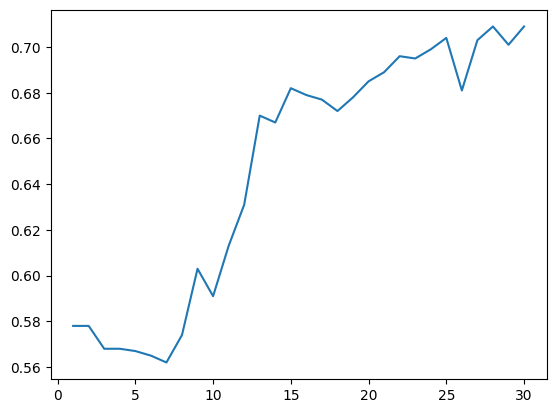

In [13]:
import matplotlib.pyplot as plt

x = range(1, 31)
y = a[i]

plt.plot(x, y)
plt.show()

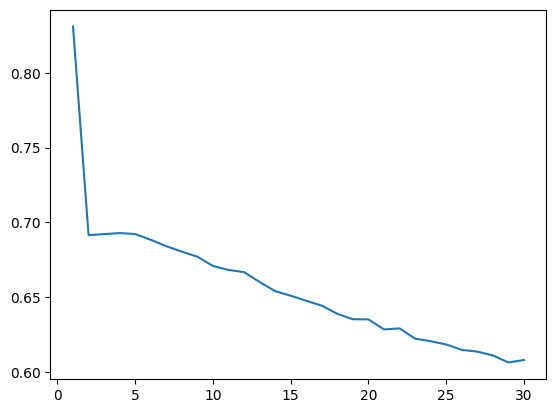

In [14]:
import matplotlib.pyplot as plt

x = range(1, 31)
y = l[i]

plt.plot(x, y)
plt.show()

In [15]:
print(torch.tensor(a[i]).tolist())
print(torch.tensor(l[i]).tolist())

[0.578000009059906, 0.578000009059906, 0.5680000185966492, 0.5680000185966492, 0.5669999718666077, 0.5649999976158142, 0.5619999766349792, 0.5740000009536743, 0.6029999852180481, 0.5910000205039978, 0.6129999756813049, 0.6309999823570251, 0.6700000166893005, 0.6669999957084656, 0.6819999814033508, 0.6790000200271606, 0.6769999861717224, 0.671999990940094, 0.6779999732971191, 0.6850000023841858, 0.6890000104904175, 0.6959999799728394, 0.6949999928474426, 0.6990000009536743, 0.7039999961853027, 0.6809999942779541, 0.703000009059906, 0.7089999914169312, 0.7009999752044678, 0.7089999914169312]
[0.8309479355812073, 0.691417932510376, 0.6921341419219971, 0.6927967667579651, 0.6921792030334473, 0.6882975697517395, 0.6840277910232544, 0.6803944110870361, 0.676985502243042, 0.6708440780639648, 0.6681538820266724, 0.6666931509971619, 0.6601027250289917, 0.653981626033783, 0.6509130597114563, 0.6475329399108887, 0.64427250623703, 0.6387977600097656, 0.6352084875106812, 0.6351004242897034, 0.62837